# Scraping

In [1]:
from selenium import webdriver
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.support import expected_conditions
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.support.ui import Select

from bs4 import BeautifulSoup
import requests
from lxml import html

import time
import datetime as dt 
import pandas as pd

import pickle
import os


import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')

In [2]:
url='https://edition.cnn.com/'

driver=webdriver.Edge()
driver.maximize_window()
driver.execute_script('document.body.style.zoom="50%"')

In [ ]:
driver.get(url)

In [ ]:
driver.find_element(By.CSS_SELECTOR,'div[class="header__container"] button[id="headerSearchIcon"]').click()

In [ ]:
search_bar_element=driver.find_element(By.CSS_SELECTOR,'div[class="search-bar"] input[class="search-bar__input"]')
search_bar_element.send_keys('China')
search_bar_element.send_keys(Keys.RETURN)

time.sleep(5)

In [ ]:
all_article_urls=[]

while True:
    try:
        next_page_button=WebDriverWait(driver,10).until(expected_conditions.element_to_be_clickable((By.CSS_SELECTOR,'div[class="pagination-bar"] div[class="pagination-arrow pagination-arrow-right search__pagination-link text-active"]')))
    except:
        break
    
    driver.execute_script('arguments[0].scrollIntoView();',next_page_button)
    time.sleep(1)

    articles=driver.find_elements(By.CSS_SELECTOR,'div[class="search__results"] div[class="card container__item container__item--type-media-image container__item--type- container_list-images-with-description__item container_list-images-with-description__item--type- "] a')
    for article in articles:
        article_url=article.get_attribute('href')
        all_article_urls.append(article_url)
    time.sleep(1)

    driver.execute_script('arguments[0].click();',next_page_button)
    print(len(all_article_urls),end='\r')

    time.sleep(2)


driver.quit()


In [3]:
path=r'D:\python data\ws_China news'

In [ ]:

pickle.dump(all_article_urls,open(os.path.join(path,'all_article_urls.pickle'),'wb'))

In [ ]:
all_article_urls=pickle.load(open(os.path.join(path,'all_article_urls.pickle'),'rb'))
all_article_urls=list(set(all_article_urls))

all_article_urls=[i for i in all_article_urls if '/videos/' not in str(i)]

len(all_article_urls)

In [ ]:
def return_info_dict(article_url):

    try:
        soup=BeautifulSoup(requests.get(article_url).content,'html.parser')
    except:
        pass

    try:
        headline=soup.select_one('section[class="layout__top layout-with-rail__top"] h1[data-editable="headlineText"]').text.replace('\n','').strip()
    except:
        headline=None

    try:
        author=soup.select_one('div[class="headline__sub-text"] a[class="byline__link"]').text.replace('\n','').strip()
    except:
        author=None

    try:
        published_on=soup.select_one('div[class="headline__sub-text"] div[class="timestamp"]').text.replace('\n','').strip()
    except:
        published_on=None

    try:
        article_content='\n'.join(([i.text.replace('\n','').strip() for i in soup.select('main[class="article__main"] div[class="article__content-container"] p[class="paragraph inline-placeholder"]')]))
    except:
        article_content=None

    info_dict={'URL':article_url,'Headline':headline,'Author':author,'Published On':published_on,'Article Content':article_content}
    return info_dict


In [ ]:
all_data=[]

for i, article_url in enumerate(all_article_urls,start=1):
    info_dict=return_info_dict(article_url)
    all_data.append(info_dict)

    #if i%500==0 or i==len(all_article_urls):
    #    pickle.dump(all_data,open(os.path.join(path,f'all_data_{i}.pickle'),'wb'))
    #    all_data=[]
        

    print(i,end='\r')

In [4]:
#pickle.dump(all_data,open(os.path.join(path,f'all_data.pickle'),'wb'))
all_data=pickle.load(open(os.path.join(path,f'all_data.pickle'),'rb'))

# Data Processing

In [5]:
df=pd.DataFrame(all_data)

In [6]:
#df.to_csv(os.path.join(path,'CNN_China_related_news.csv'),index=False)

In [7]:
df

,URL,Headline,Author,Published On,Article Content
0,https://www.cnn.com/2021/06/11/middleeast/uygh...,Rubio says US must fight China’s ‘extraterrito...,Jomana Karadsheh,"Updated 2:13 PM EDT, Fri June 11, 2021",US Sen. Marco Rubio said Thursday that the Uni...
1,https://www.cnn.com/2021/03/29/europe/uyghur-i...,"These children escaped Xinjiang, but their par...",None,"Published 8:21 AM EDT, Mon March 29, 2021",It’s been nearly five years since Hassan heard...
2,https://www.cnn.com/2020/05/08/economy/china-u...,None,Laura He,"Updated 4:31 AM EDT, Fri May 8, 2020",Wang is used to job hunting in China.\nThe 26-...
3,https://www.cnn.com/2020/06/08/tech/jd-hong-ko...,JD.com becomes the latest Chinese company to t...,Sherisse Pham,"Published 1:51 AM EDT, Mon June 8, 2020",JD.com is planning a secondary listing for its...
4,https://www.cnn.com/2021/05/30/asia/china-carg...,China’s cargo spacecraft docks with space stat...,None,"Published 2:56 AM EDT, Sun May 30, 2021","China’s cargo spacecraft, carrying supplies, e..."
...,...,...,...,...,...
4513,https://www.cnn.com/2021/09/22/investing/everg...,China’s Evergrande meets crucial debt deadline...,Laura He,"Updated 4:27 AM EDT, Wed September 22, ...",China’s Evergrande Group will pay interest due...
4514,https://www.cnn.com/asia/live-news/china-party...,None,None,None,
4515,https://www.cnn.com/2020/01/15/tech/jeff-bezos...,Jeff Bezos is in India. Amazon has a ton on th...,Michelle Toh,"Published 6:07 AM EST, Wed January 15, ...",Amazon (AMZN) is ra...
4516,https://www.cnn.com/2022/11/08/investing/perfe...,Taiwan’s virtual beauty brand struggles on Wal...,Michelle Toh,"Published 12:52 AM EST, Tue November 8,...",Taiwan’s latest entrant to Wall Street has had...


In [8]:
df.isna().mean()

URL                0.000000
Headline           0.083223
Author             0.185259
Published On       0.013280
Article Content    0.000443
dtype: float64

In [9]:
df=df.dropna(subset='Article Content')

In [10]:
df['Published On']=df['Published On'].apply(lambda x:''.join(x.split(',')[1:]) if isinstance(x,str) else None).apply(pd.to_datetime,errors='coerce')

# Sentiment Analysis

In [11]:
import nltk

from nltk.sentiment import SentimentIntensityAnalyzer
sia=SentimentIntensityAnalyzer()

from nltk.stem import WordNetLemmatizer
lemmatizer=WordNetLemmatizer()

from nltk.corpus import stopwords
stopwords=stopwords.words('english')

tokenizer=nltk.RegexpTokenizer(r'\w+')


In [12]:
def text_sentiment_scores(text):
    text_tokenized=nltk.word_tokenize(text)
    text_lower=[w.lower() for w in text_tokenized]
    text_lemmatized=[lemmatizer.lemmatize(w) for w in text_lower]
    text_filtered=[w for w in text_lemmatized if w not in stopwords]
    final_text=' '.join(text_filtered)
    
    score=sia.polarity_scores(final_text)
    return score

In [ ]:
scores = []

for i,text in enumerate(df['Article Content']):
    if isinstance(text, str):
        scores.append(text_sentiment_scores(text))
    else:
        scores.append(None)

    if i%100==0:
        print(i,end='\r')

In [13]:
#pickle.dump(scores,open(os.path.join(path,f'scores.pickle'),'wb'))
scores=pickle.load(open(os.path.join(path,f'scores.pickle'),'rb'))

In [14]:
df['Sentiment Score']=[score['pos'] if isinstance(score,dict) else None for score in scores]

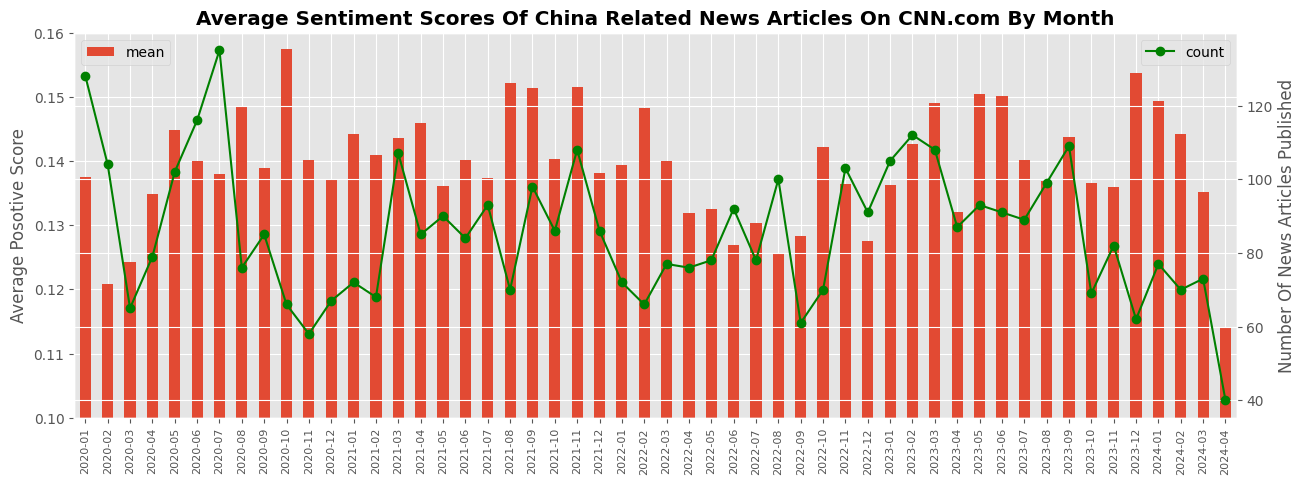

In [15]:
g=df.groupby(df['Published On'].dt.to_period('M'))['Sentiment Score'].agg(['count','mean']).reset_index()

fig,ax=plt.subplots(figsize=(15,5))
ax2=ax.twinx()

g.plot.bar(ax=ax,y='mean')
g.plot.line(ax=ax2,y='count',marker='o',color='green')
ax.set_ylim(0.1,0.16)
ax.set_xticklabels(g['Published On'],size=8)
ax.set_title('Average Sentiment Scores Of China Related News Articles On CNN.com By Month',fontweight='bold')
ax.legend(loc='upper left')
ax.set_ylabel('Average Posotive Score')
ax2.set_ylabel('Number Of News Articles Published')
plt.show()

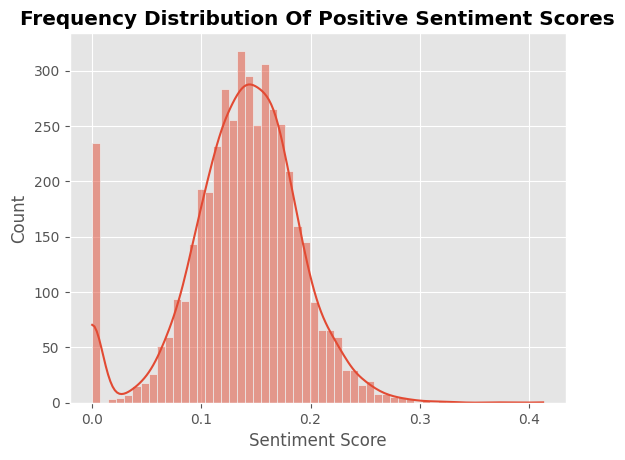

In [16]:
sns.histplot(df,x='Sentiment Score',kde=True)
plt.title('Frequency Distribution Of Positive Sentiment Scores',fontweight='bold')
plt.show()

<Axes: title={'center': 'Average Positive Sentiment Scores By Author'}, xlabel='Author'>

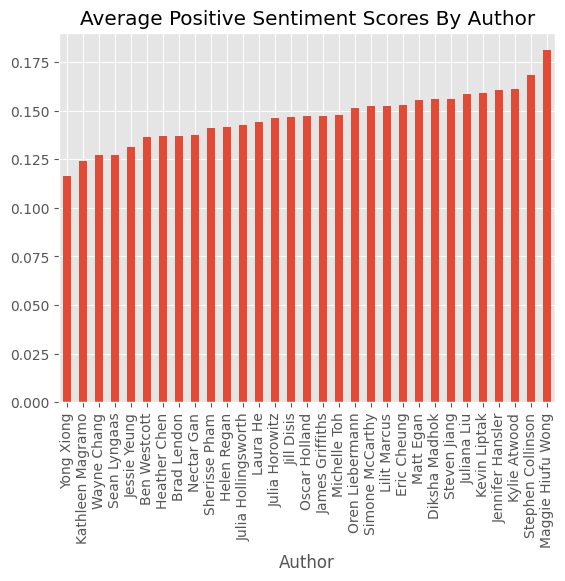

In [17]:
df.groupby('Author').filter(lambda x:x['URL'].count()>20)\
.groupby('Author')['Sentiment Score'].mean().sort_values(ascending=True)\
.plot.bar(title='Average Positive Sentiment Scores By Author')

# NLP

In [18]:
all_words=[]
for i,text in enumerate(df['Article Content']):
    try:
        tokenized=tokenizer.tokenize(text)
        tokens_lowered=[t.lower() for t in tokenized]
        lemmatized=[lemmatizer.lemmatize(t) for t in tokens_lowered]
        tokens=[t for t in lemmatized if t not in stopwords]
        for token in tokens:
            all_words.append(token)
    except:
        continue
    if i%100:
        print(f'{i}/{len(df)}',end='\r')

In [19]:
word_count={}

for word in all_words:
    if word not in word_count:
        word_count[word]=0
    else:
        word_count[word]+=1

word_count=dict(sorted(word_count.items(),key=lambda item:item[1],reverse=True))
word_count #most used words

{'china': 42241,
 'said': 27141,
 'ha': 22727,
 'chinese': 21470,
 'u': 17612,
 'wa': 17427,
 'year': 13763,
 'country': 11397,
 'beijing': 10633,
 'state': 10348,
 'also': 10028,
 'government': 8558,
 'people': 7988,
 'company': 7633,
 'according': 7149,
 'one': 7073,
 'new': 6988,
 'would': 6958,
 'last': 6955,
 'official': 6950,
 'world': 6551,
 'taiwan': 6522,
 'time': 6248,
 'hong': 6162,
 'two': 6106,
 'kong': 5950,
 'could': 5638,
 'month': 5549,
 'city': 5507,
 'xi': 5214,
 'week': 4978,
 'first': 4933,
 'united': 4815,
 'covid': 4694,
 'since': 4625,
 'foreign': 4524,
 'security': 4384,
 'national': 4369,
 'medium': 4258,
 'including': 4185,
 'military': 4157,
 'many': 4139,
 'global': 4111,
 'day': 4108,
 'market': 4090,
 'cnn': 4060,
 'president': 4050,
 'international': 3875,
 'business': 3821,
 'say': 3819,
 'million': 3777,
 'party': 3705,
 'economic': 3670,
 'report': 3667,
 'even': 3654,
 'statement': 3622,
 'economy': 3590,
 'like': 3588,
 'told': 3554,
 'may': 3487,
 

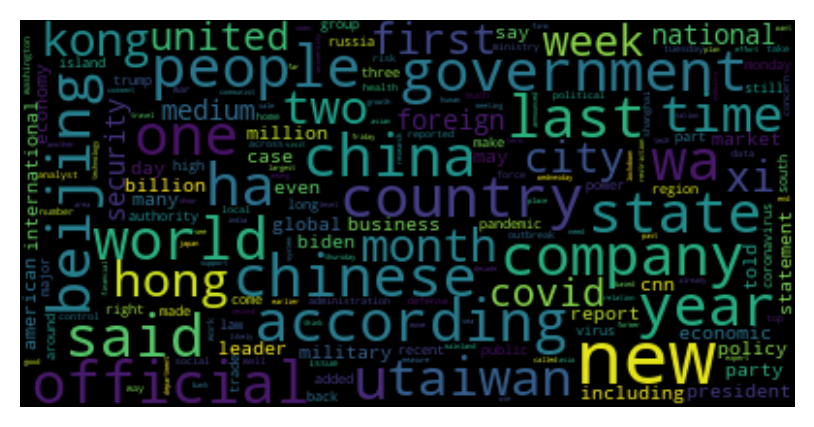

In [20]:
from wordcloud import WordCloud

wordcloud = WordCloud(max_font_size=40).generate(" ".join([(k + ' ') for i,(k, v) in enumerate(word_count.items()) if i<=200]))

plt.figure(figsize=(5,5),dpi=200)
plt.imshow(wordcloud, interpolation="bilinear",cmap='Greens')
plt.axis("off")
plt.show()

In [21]:
from nltk import ngrams
from collections import Counter

target_words = ['xi', 'China', 'Chinese', 'covid', 'government', 'state', 'Beijing', 'company', 'USA', 
                'Taiwan', 'military', 'global', 'business', 'people', 'official', 'policy', 'american', 'hong',
                'kong', 'political', 'health', 'India', 'Japan', 'asia', 'Korea','sea','lockdown','pandemic','tech','industry','financial'
                'relation','nation','bank']


def get_most_common_words(year):
    filtered_df=df[df['Published On'].dt.year==year]
    article_texts = filtered_df['Article Content'].dropna()
    all_text = ' '.join(article_texts)

    words = all_text.split()
    words=[w for w in words if w not in stopwords]

    bigrams = ngrams(words, 2)
    filtered_bigrams = [bigram for bigram in bigrams if any(word in target_words for word in bigram)]

    filtered_bigram_counts = Counter(filtered_bigrams)
    filtered_bigram_df = pd.DataFrame(filtered_bigram_counts.items(), columns=['Bigram', 'Count'])

    to_replace=[',','.']
    for i in to_replace:
        filtered_bigram_df['Bigram'] = filtered_bigram_df['Bigram'].apply(lambda bigram: (bigram[0].replace(i, ''), bigram[1].replace(i, '')))
    filtered_bigram_df=filtered_bigram_df.groupby('Bigram')['Count'].sum().reset_index().sort_values('Count',ascending=False)
    top_filtered_bigram_df=filtered_bigram_df.head(20)

    texts=top_filtered_bigram_df['Bigram'].apply(lambda x:x[0]+' '+x[1])
    count_dict={}
    for text in texts:
        count_dict[text] = 0
        for article in filtered_df['Article Content'].dropna():
            if text in article:
                count_dict[text]+=1
    sorted_count_dict = dict(sorted(count_dict.items(), key=lambda item: item[1], reverse=True))
    percentage_dict={}
    for text, unique_count in sorted_count_dict.items():
        percentage_dict[text]=unique_count/len(filtered_df['Article Content'].dropna())
    
    return percentage_dict

In [22]:
years=list(sorted((df['Published On'].dt.year).unique()))
years = [int(year) for year in years if not pd.isnull(year)]


all_dicts={}
for year in years:
    percentage_dict=get_most_common_words(year)
    all_dicts[year]=percentage_dict
    #print(year,end='\r')

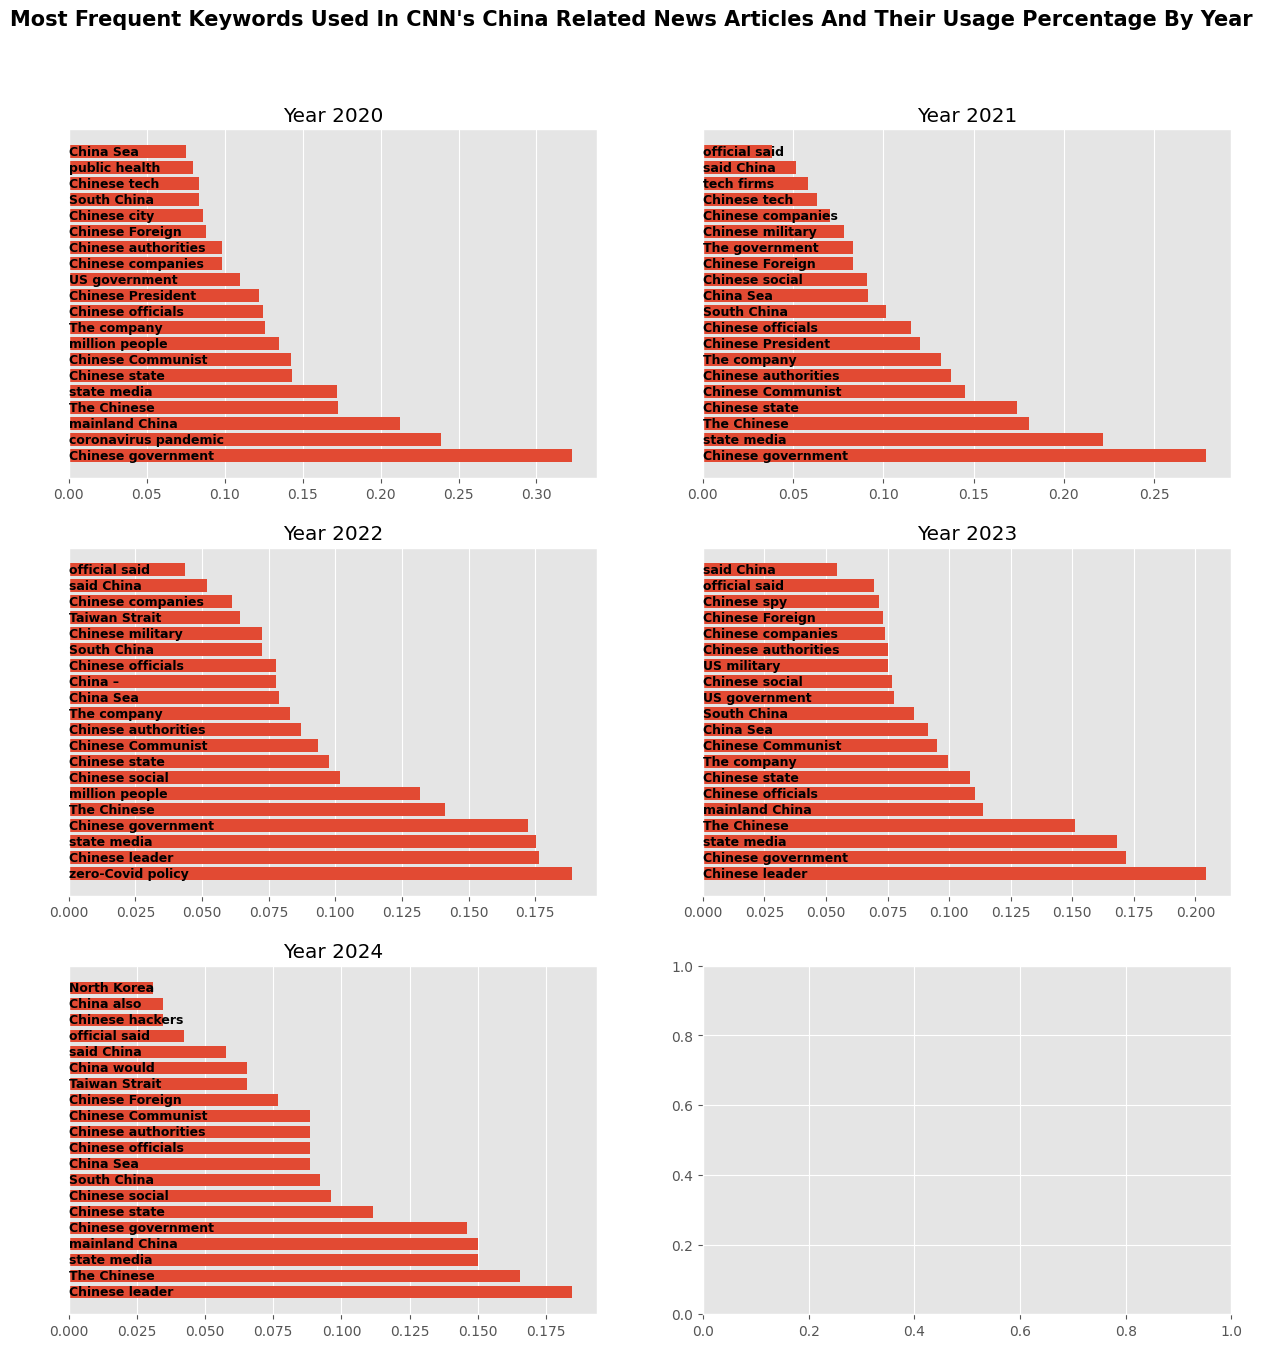

In [23]:
fig,axes=plt.subplots(3,2,figsize=(15,15),dpi=100)

for ax,(year,percentage_dict) in zip(axes.ravel(),all_dicts.items()):
    ax.barh(y=[k for k,v in percentage_dict.items()],width=[v for k,v in percentage_dict.items()])
    ax.set_yticks([])
    ax.set_title(f'Year {year}')
    for i in range(len(percentage_dict)):
        ax.text(y=[k for k,v in percentage_dict.items()][i],x=0,s=[k for k,v in percentage_dict.items()][i],fontweight='bold',va='center',size=9)

plt.subplots_adjust(top=0.9, hspace=0.2)
plt.suptitle("Most Frequent Keywords Used In CNN's China Related News Articles And Their Usage Percentage By Year", fontweight='bold',size=15)
plt.show()